# Assignment 5

Follow the instructions provided in this notebook and in the lectures.

In [1]:
import codecs

import matplotlib.pyplot as plt
from matplotlib import pylab

import numpy as np

import pickle

import os

import scipy.sparse as ss

from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [2]:
pylab.rcParams['figure.figsize'] = (10, 8)
pylab.rcParams['contour.negative_linestyle'] = 'solid'

In [3]:
# Set this variable to last two digits of your A# and then run the cell.

last_two_digits = 72

## Load Data

In [4]:
if os.path.isfile("mnist.pickle.z"):
    
    with open("mnist.pickle.z", 'rb') as f:
        compressed_data = f.read()

    uncompressed_data = codecs.decode(compressed_data, 'zlib_codec')
    mnist = pickle.loads(uncompressed_data)

else:
    
    mnist = fetch_openml('mnist_784', version=1)
    compressed_data = codecs.encode(pickle.dumps(mnist), 'zlib_codec')
    with open("mnist.pickle.z", 'wb') as f:
        f.write(compressed_data)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
X = mnist.data
y = mnist.target

In [8]:
subclasses = ['3', '9']

chosen_bool = np.full((X.shape[0], ), False)

for sc in subclasses:
    chosen_bool = np.logical_or(chosen_bool, y==sc)

X = X[chosen_bool]
y = y[chosen_bool]

In [9]:
X.shape

(14099, 784)

In [10]:
rs = np.random.RandomState(42)
shuffle = rs.permutation(X.shape[0])
X = X[shuffle]
y = y[shuffle]

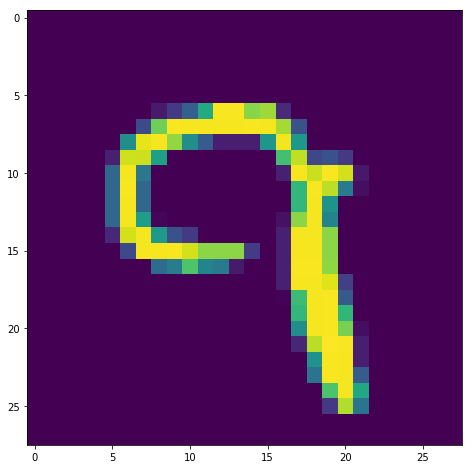

In [11]:
plt.imshow(X[0].reshape(28, 28))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=last_two_digits, test_size=1/3)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
g=1/(X_train.shape[1]*X_train.var())
g

0.001626016260162601

## Q1: Display the Kernel Matrix - v1

First, create a new_X_train, where "3"s come first and then come "9"s. The order of 3s and 9s are the same order they appear in X_train. Then, compute the rbf kernel with gamma = g parameter. See sklearn.metrics.pairwise_kernels.

In [15]:
idx_3 = []
idx_9 = []
for y in range(len(y_train)):
    if y_train[y] == '3':
        idx_3 += [y]
    else:
        idx_9 += [y]
idx = idx_3 + idx_9

In [16]:
new_X_train = X_train[idx]
K=pairwise_kernels(new_X_train,metric='rbf', gamma=g)

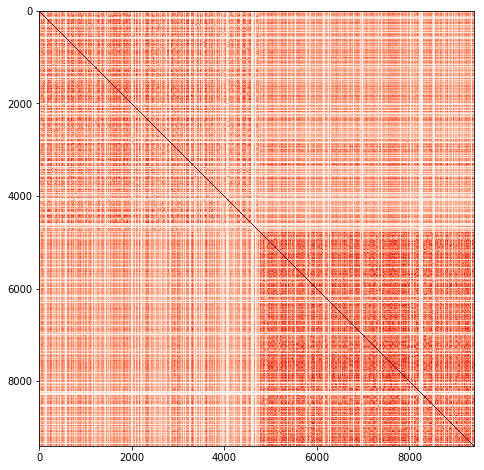

In [17]:
plt.imshow(K,cmap='Reds')

## Q2: Display the Kernel Matrix - v2

First, create a new_2_X_train, where "3"s come first and then come "9"s. However, this time, 3s that are more similar to 3s come first, and 9s that are more similar to 9s come last.

In [18]:
K_3=pairwise_kernels(X_train[idx_3],metric='rbf', gamma=g)
K_9=pairwise_kernels(X_train[idx_9],metric='rbf', gamma=g)

In [19]:
sim_3 = sum(K_3)
sim_9 = sum(K_9)

In [20]:
sim_idx_3 = np.unravel_index(np.argsort(sim_3, axis=None), sim_3.shape)
sim_idx_9 = np.unravel_index(np.argsort(sim_9, axis=None), sim_9.shape)

In [21]:
new_2_X_train = np.concatenate((new_X_train[sim_idx_3][::-1], new_X_train[len(idx_3):][sim_idx_9]))

In [22]:
K=pairwise_kernels(new_2_X_train,metric='rbf', gamma=g)

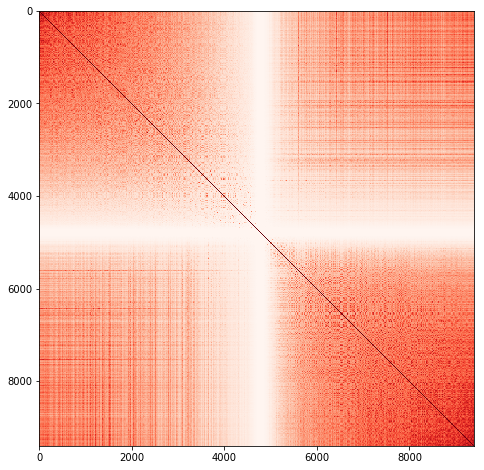

In [23]:
plt.imshow(K,cmap='Reds')

## Fit SVM

In [24]:
svm = SVC(kernel='rbf', gamma=g, C=1)
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.99680817108203
0.985531914893617


In [25]:
len(svm.support_)

1169

## Q3: Explain the prediction of

1. Most-likely "3"
2. Most-likely "9"
3. Most uncertain

in X_test.

Imagine the features are the kernel values to support vectors, and their weights are dual_coef_. Display the following info, for each of the above cases:

1. The ID and the image
2. The evidence for "3"
3. The evidence for "9"
4. The impact and the image of the top five support vectors that impacted this decision

Hint 1: use evidence matrix and evidence array from one of the previous assignments.
Hint 2: for SVMs, do not use predict_proba to determine which ones are most likely "3" or "9" or "uncertain". Instead, use the output of the decision_function.

In [26]:
def evidence_matrix(X, w):
    """Given a data matrix X and a weight array w, compute and return evidence matrix."""
    A = np.array(X)
    return A*w

def evidence_array(M):
    """Given an evidence matrix M, calculate an evidence array."""
    A = np.array(M)
    lst = []
    for a in A:
        pos = 0
        neg = 0
        for r in a:
            if r > 0:
                pos += r
            else:
                neg += r
        lst += [[neg, pos]]
    return np.array(lst)

In [27]:
df = svm.decision_function(X_test)
K = pairwise_kernels(X_test,svm.support_vectors_,metric='rbf', gamma=g)
em = evidence_matrix(K, svm.dual_coef_[0])
ea = evidence_array(em)

For the rest of the code to work, you need

* df - the output of the decision function of the svm on X_test
* K - the kernel between X_test and the support vectors (rbf kernel with gamma = g)
* em - the evidence matrix calculated using the kernel and the dual coefficients
* ea - the evidence array calculated using em

### Most-likely 3

In [28]:
i = np.argmin(df)
i

2626

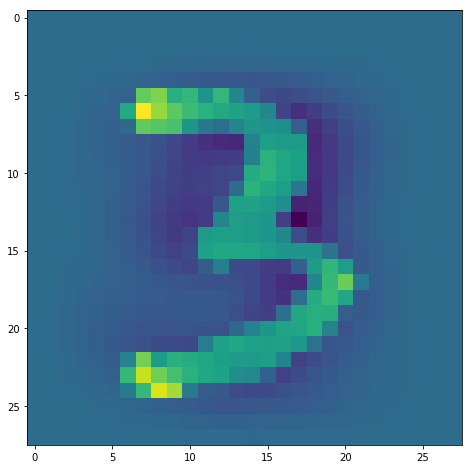

In [29]:
plt.imshow(X_test[i].reshape(28, 28))

In [30]:
ea[i]

array([-81.04299073,  77.52966329])

In [31]:
inds = np.argsort(np.abs(em[i]))[::-1]
em[i, inds[:5]]

array([-0.62003909, -0.55487652, -0.54025914,  0.53074859, -0.53072553])

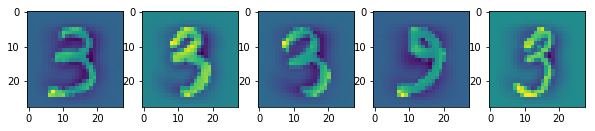

In [32]:
for j in range(1, 6):
    plt.subplot(1, 5 , j)
    plt.imshow(svm.support_vectors_[inds[j-1]].reshape(28, 28))

###  Most-likely 9

In [33]:
i = np.argmax(df)
i

3602

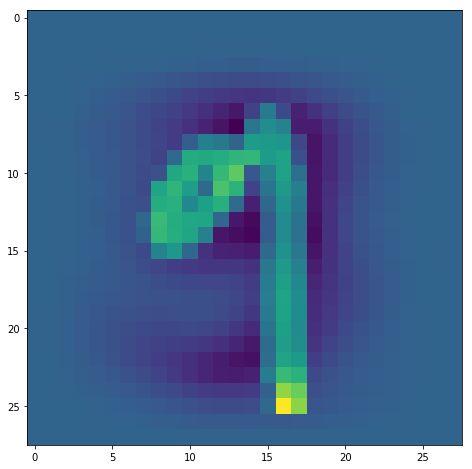

In [34]:
plt.imshow(X_test[i].reshape(28, 28))

In [35]:
ea[i]

array([-89.55176681,  92.51554638])

In [36]:
inds = np.argsort(np.abs(em[i]))[::-1]
em[i, inds[:5]]

array([0.65268136, 0.64397735, 0.6423355 , 0.6374267 , 0.63488581])

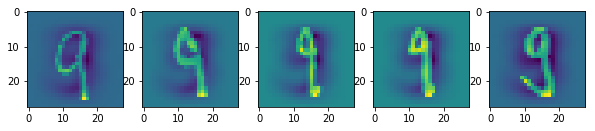

In [37]:
for j in range(1, 6):
    plt.subplot(1, 5 , j)
    plt.imshow(svm.support_vectors_[inds[j-1]].reshape(28, 28))

### Most Uncertain

In [38]:
i = np.argmin(np.abs(df))
i

1106

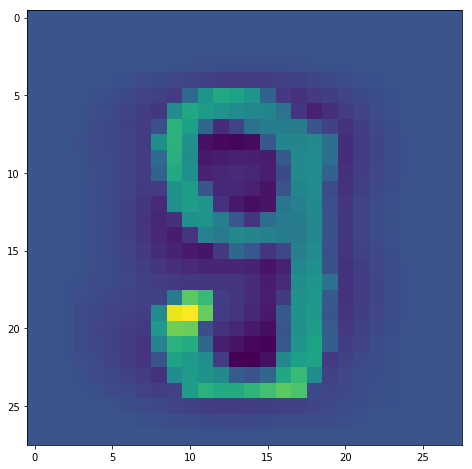

In [39]:
plt.imshow(X_test[i].reshape(28, 28))

In [40]:
ea[i]

array([-80.49370444,  80.59393765])

In [41]:
inds = np.argsort(np.abs(em[i]))[::-1]
em[i, inds[:5]]

array([-0.68287302,  0.68080599,  0.67409107,  0.6687554 ,  0.66660602])

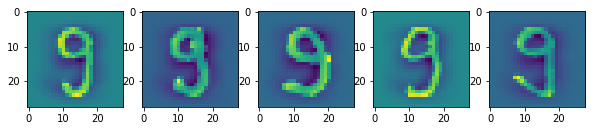

In [42]:
for j in range(1, 6):
    plt.subplot(1, 5 , j)
    plt.imshow(svm.support_vectors_[inds[j-1]].reshape(28, 28))

## Q4: Discuss your findings.

Display the Kernel V1:

    In this prcocess, it was interesting to see a cluster on the points at the 2nd and 4th quadrants. This seperation is due ordering the 3s to the front and 9s to the back. The 3rd and 1st quardrants are scattered due to different similarities (not ordering the 3s and 9s)

Display the Kernel V2:

    In this prcocess, it was interesting to see a cluster on the points at the 2nd and 4th but now the clusters are at the corners. This time, the 1sr and 3rd quadrants are better seperated since the data is now ordered by similarity.
    
Explain Prediction:

    Most-Likely 3:
    
        The abs of ea shows the [0] having a higher than [1] by a huge amount (as evidence it is most likely to be 3).
        The em of 9 are very small numbers it terms of value
        All the svms are definately 3s except for 4 which seems to me as it should not be mapped as most likely 3
   
   Most-Likely 9:
   
        The abs of ea shows the [1] having a higher than [0] by a huge amount (as evidence it is most likely to be 9).
        The em of 3 are very small numbers it terms of value
        All the svms are definately 3s except for 5 which seems to me as it should not be mapped as most likely 3
    
    Most Uncertain:
    
        The abs of ea shows the [0] and [1] are very close (leaning towards [1] so mosre likely to be 9)
        The em of 9 are very small numbers it terms of value[2:5] and 3 are very small [1]
        All the svms are definately have the tail at the bottom that was present as 4th in the most likely 3 case and 5th in most likely 9 case.
        
Observations:

    Even though svms did a good job in predicting the values, there was some miscasifications in the "most" likey predictions. In these miss predictions, it is apparent that the svm tried to pattern match the presicted class. The bottom curveture of the uncertain screams 3 to me but the classfiers seems to lean towards 9 when this feature is present. Overall, the evidence backs up the display with some questions regarding which parts of the image it looks at to make the choices.